# Statistics Hands-on session for Lecture 4


<font color='red'>Students are required to hand in the exercises and questions below in the form of a SWAN notebook or pdf file (with code snippets) by Wednesday, May 23. Please send the material to Anna Sfyrla (anna.sfyrla@cern.ch) and T.J. Khoo. (Teng.Jian.Khoo@cern.ch).</font>

# Hands-on experience with RooUnfold

In this demonstration, we will experiment with some tools that are commonly used for unfolding distributions in measurements at the LHC. Specifically, we will use the `RooUnfold` package, available here: http://hepunx.rl.ac.uk/~adye/software/unfold/RooUnfold.html

*Note: if you are not running this with the provided directory, you will need to download or check out the trunk of RooUnfold via the link above. You can then compile it locally by setting up ROOT and just using "make" according to the instructions above. You can also compile it on SWAN by uploading the files to CERNBox, then opening the SWAN console.*

In [1]:
import ROOT
# Plot formatting and interactivity
#ROOT.enableJSVis()
ROOT.gStyle.SetOptStat(0) # Disable stat box
ROOT.gStyle.SetMarkerStyle(ROOT.kFullCircle)
ROOT.gStyle.SetMarkerSize(0.7)
ROOT.gStyle.SetHistLineWidth(2)
c = ROOT.TCanvas("origami")

# Load ROOUnfold library and classes
ROOT.gSystem.Load("RooUnfold/libRooUnfold") # This library needs to be built and available

from ROOT import cout # for printing from RooUnfold
from ROOT import RooUnfoldResponse
# You should recognise the following unfolding methods from the lecture
from ROOT import RooUnfoldBinByBin
from ROOT import RooUnfoldInvert
from ROOT import RooUnfoldBayes
from ROOT import RooUnfoldIds
from ROOT import RooUnfoldSvd

Welcome to JupyROOT 6.28/06


RooUnfold implements several unfolding methods. Rather than dig into the details of any one method, we will just see how to set up a basic `RooUnfold` workflow and apply this to some signal hypotheses under different assumptions about the detector and background effects to see how they can be dealt with.

## Initial setup

The point of unfolding is to work backwards from a reconstructed detector measurement to the "bare physics process", defined at some level.

So, we will first define a "detector smearing" function that we can apply to our own functions defining the "true" physics. This simulates several detector effects:
* efficiency (loss of events)
* response (measurement bias)
* resolution (scatter of the measurement)

Feel free to experiment with different choices here, e.g. changing the efficiency dependence on xtrue, applying a varying bias, or a non-Gaussian smearing.

In [2]:
# Return a random bool telling us if we should drop an event based on the efficiency for the value of xtrue
def rejectEvent(xtrue):
    eff = 0.5 + (1.0-0.5)*abs(xtrue/5.);  #  efficiency function
    return ROOT.gRandom.Rndm()>eff

# apply a bias to the observable value (could be made conditional on xtrue)
def getBias(xtrue):
    bias = 0.2
    return bias # simple shift

# smear the observable value (could be made conditional on xtrue)
def getSmearing(xtrue):
    xsmear = ROOT.gRandom.Gaus(0.,0.1)
    return xsmear

# apply all effects listed above
def applyDetectorEffects(xtrue):
    if rejectEvent(xtrue): return None
#    xreco = xtrue
#    xreco = xtrue + getBias(xtrue)
#    xreco = xtrue + getSmearing(xtrue)
    xreco = xtrue + getBias(xtrue) + getSmearing(xtrue)
    return xreco

Now, we define two functions, one of which we will treat as our model which is used for unfolding (think of it as signal Monte Carlo simulation), and another which we will treat as the true behaviour.

For something fairly obvious, we use sin and cos with the same period, but you can modify these instead to be a peaking function e.g. Breit-Wigner, or to two sinusoidal functions with different periods. Or, you could use a falling function, like different exponentials.

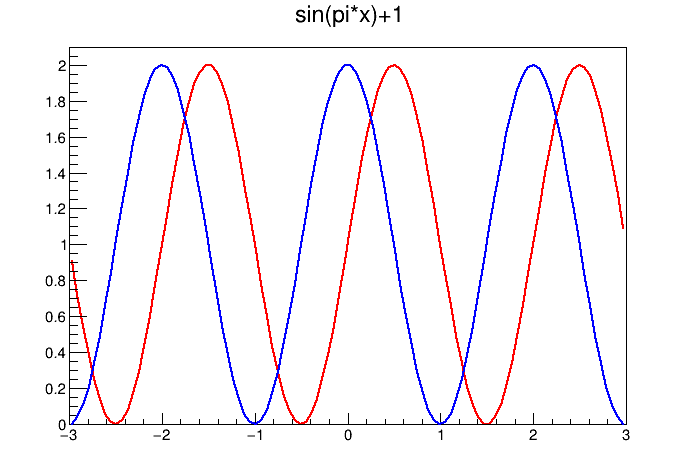

In [3]:
xmin = -3
xmax = 3
fmodel = ROOT.TF1('fmodel','sin(pi*x)+1',xmin,xmax) # This is our "signal MC truth"
freal = ROOT.TF1('freal','cos(pi*x)+1',xmin,xmax)  # This is "really" what underlies the data
# One alternative option
#fmodel = ROOT.TF1('fmodel','TMath::Gaus(x,1,0.2)',xmin,xmax) # This is our "signal MC truth"
#freal = ROOT.TF1('freal','TMath::Landau(x,1,0.18,1)',xmin,xmax)  # This is "really" what underlies the data
freal.SetLineColor(ROOT.kBlue)
fmodel.Draw()
freal.Draw("same")
c.Draw()

In [4]:
# Generate histograms that we will fill from the model before and after detector effects
nbins = 30
model_truth = ROOT.TH1D('model_truth','model_truth',nbins,xmin,xmax)
model_truth.Sumw2()
model_meas = ROOT.TH1D('model_meas','model_meas',nbins,xmin,xmax)
model_meas.Sumw2()

Just for a sanity check, fill and plot the histograms using the functions we defined, applying detector effects to get a "realistic measurement".

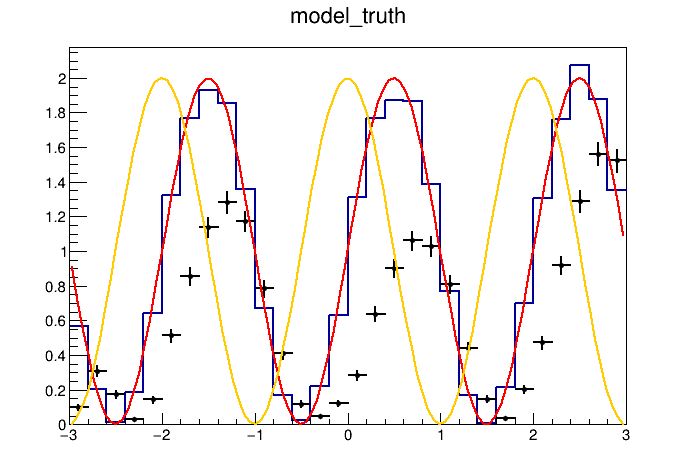

In [7]:
model_truth.Reset()
model_meas.Reset()
for i in range(10000):
    trueval = fmodel.GetRandom()
    measval = applyDetectorEffects(trueval)
    model_truth.Fill(trueval)
    if measval: # Need to check if this event was successfully measured
        model_meas.Fill(measval)

# Scale to match the function normalisation -- may need to change depending on the function you choose
int1 = model_truth.Integral() # store this temporarily
int2 = model_meas.Integral() # store this temporarily
model_meas.Scale(float(nbins)/10000)
model_truth.Scale(float(nbins)/10000)
#model_meas.Scale(1./model_truth.GetBinContent(1))
#model_truth.Scale(1./model_truth.GetBinContent(1))

model_truth.Draw('hist')
model_meas.SetLineColor(ROOT.kBlack)
model_meas.SetMarkerColor(ROOT.kBlack)
model_meas.Draw('psame')
#
fmodel.Draw("same")
freal.SetLineColor(ROOT.kOrange)
freal.Draw("same")

c.Draw()

In [8]:
# Restore original normalisation
model_truth.Scale(int1/model_truth.Integral())
model_meas.Scale(int2/model_meas.Integral())

## First steps with RooUnfold: creating the response
We now use our first RooUnfold class, the `RooUnfoldResponse` to build the response matrix. For a known "MC" value, we apply the smearing, then if the event is "accepted" (not lost), pass the truth and smeared events to the response model. If the event is lost, we just pass the truth, because we need to know what our acceptance is.

In [11]:
print ("==================================== TRAIN ====================================")
response = RooUnfoldResponse (nbins,xmin,xmax)

# Train from the model, specifying a large number of events to avoid being affected badly by statistical uncertainties
for i in range(100000):
    xtrue = fmodel.GetRandom()
    xmeas = applyDetectorEffects(xtrue)
    if xmeas!=None:
        response.Fill (xmeas, xtrue) # accepted event
    else:
        response.Miss (xtrue)        # lost event

==================================== TRAIN ====================================


Having created the response matrix, let's plot it, and try our hand at the matrix inversion approach, which was discussed in the lecture.

*Note: depending on your choice of true function and detector effects, ROOT may give errors due to the matrix being singular, in which case this is simply not an option.*

In [12]:
responseMatrix = response.Mresponse()
responseInv = responseMatrix.Clone()
responseInv.Invert()

<cppyy.gbl.TMatrixT<double> object at 0x563b2d36bfc0>

Plot the response matrix...

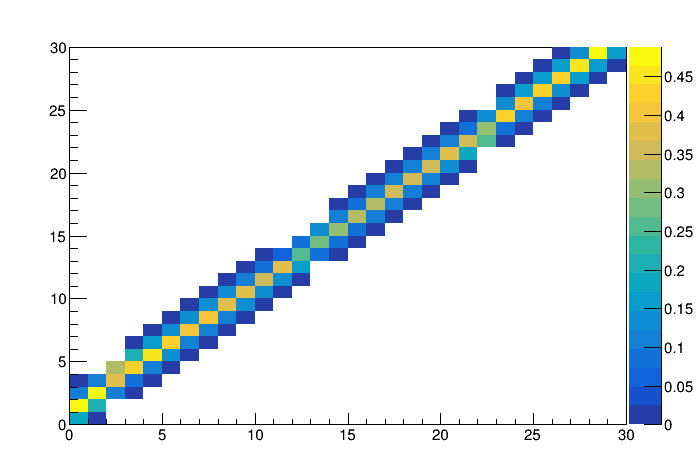

In [13]:
responseMatrix.Draw("colz")
c.Draw()

And its inverse, which seems to have some slightly alarmingly large values...

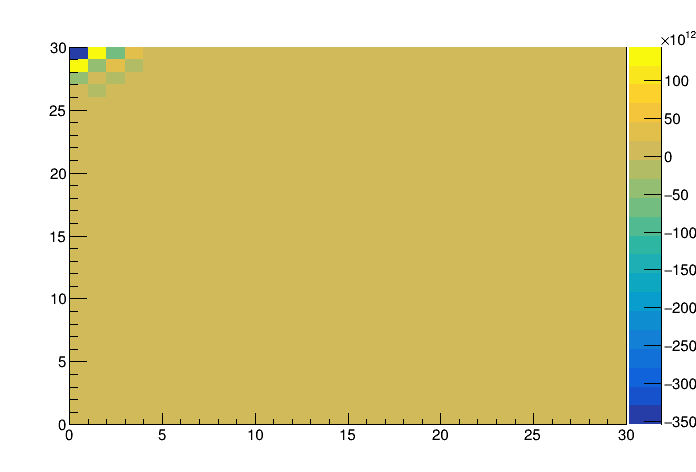

In [14]:
responseInv.Draw("colz")
c.Draw()

We can try applying the inverted response matrix to the "reco" histogram as one way to undo the detector response.

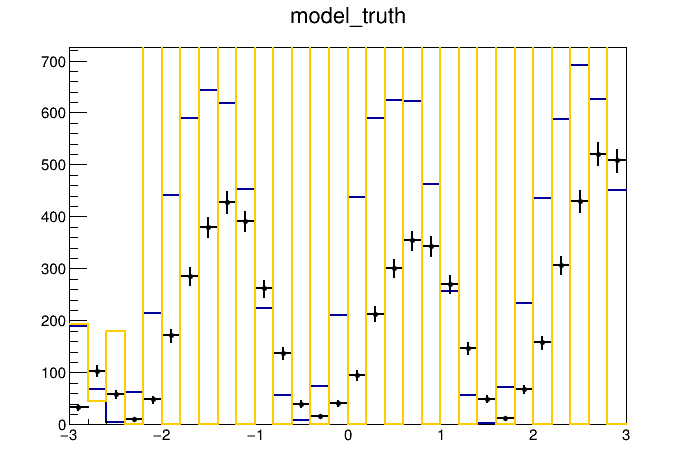

In [15]:
model_meas_Rinv = model_meas.Clone("model_meas_Rinv")
model_meas_Rinv.Reset()
for ibin in range(1,model_meas_Rinv.GetNbinsX()+1):
    matsum = 0
    for jbin in range(1,model_meas_Rinv.GetNbinsX()+1):
        matsum += model_meas.GetBinContent(jbin)*responseInv[ibin-1][jbin-1]
    model_meas_Rinv.SetBinContent(ibin,matsum)
model_truth.Draw("hist")
model_meas.Draw("pesame")
model_meas_Rinv.SetLineColor(ROOT.kOrange)
model_meas_Rinv.Draw("histsame")
c.Draw()

Oops, that's not very convincing... Let's plot the "unfolded" distribution on its own just to check. Recall what the "problems" with the simple matrix inversion were, from the lecture.

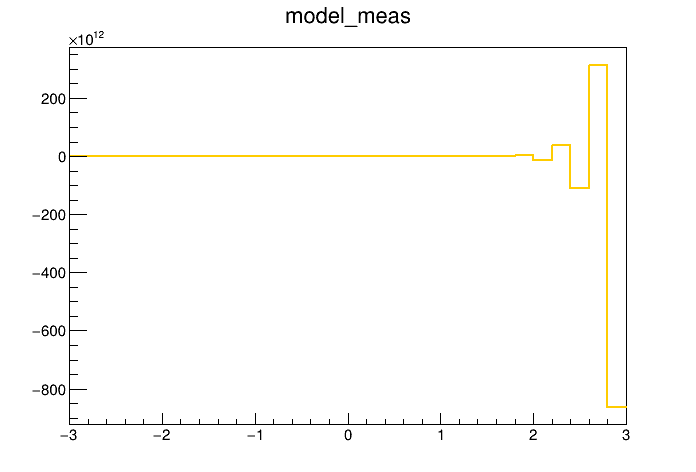

In [16]:
model_meas_Rinv.Draw("hist")
c.Draw()

## Exercise 1: <div class="alert alert-block alert-info"> How does the result of the matrix inversion change if you make the following alterations? 
<div class="alert alert-block alert-info">
* Try switching off the various detector effects (bias, efficiency, smearing) -- does any of them stand out as "problematic" for the matrix inversion? 
* Does the histogram bin size have any effect on whether the matrix inversion gives a sensible result?

## Bin-by-bin corrections

Another "simple" method that was mentioned was the bin-by-bin approach, where the unfolding is done locally with a correction factor in each bin, and the correction does not effectively spread/migrate events between bins. Let's try to do this by hand as well, by dividing the histograms, which ROOT is capable of doing easily.

If we plot the result, we observe some interesting structure. What will this mean, when we try to unfold?

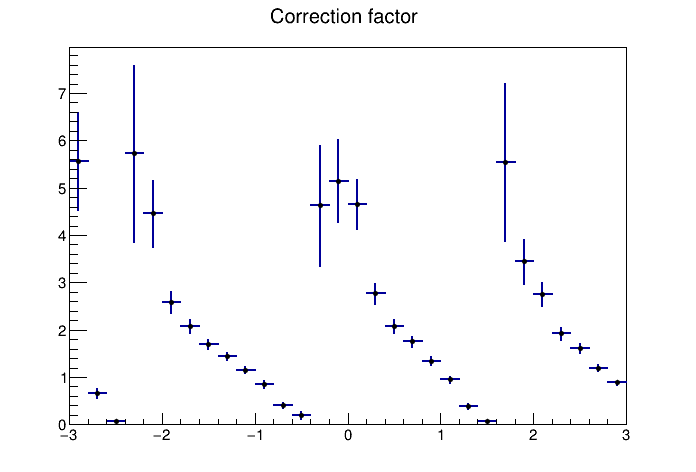

In [17]:
fcorr = model_truth.Clone("fcorr")
fcorr.SetTitle("Correction factor")
fcorr.Reset()
fcorr.Divide(model_truth,model_meas)
fcorr.Draw()
c.Draw()

Applying the correction factor of course just involves multiplying the measured histogram by the correction factor, so let's test this.

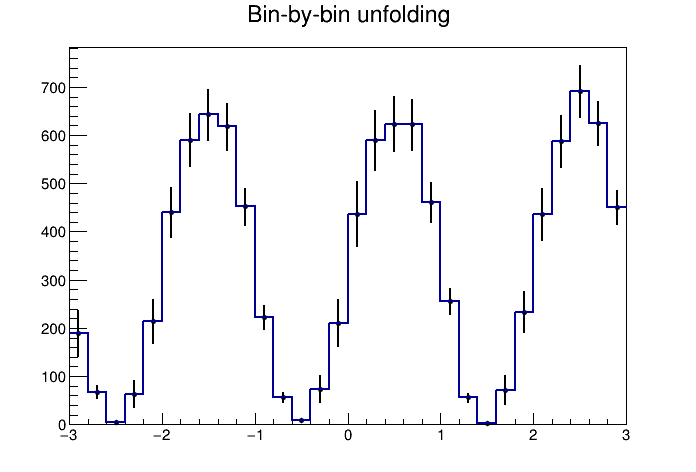

In [18]:
model_meas.Draw("pe")
model_meas_bbb = model_meas.Clone("model_meas_bbb")
model_meas_bbb.SetTitle("Bin-by-bin unfolding")
model_meas_bbb.Reset()
model_meas_bbb.Multiply(model_meas,fcorr)
model_meas_bbb.Draw()
model_meas_bbb.Draw()
model_truth.Draw("histsame")
c.Draw()

Perfect! But we want to unfold the "real data", so let's make a histogram of this, and see whether we succeed. We can also test it at the same time allowing for a bit more statistical fluctuation in the MC.

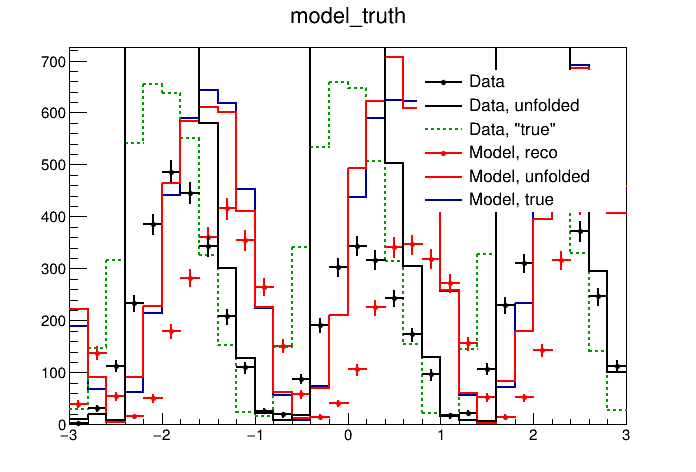

In [20]:
model_meas_test = model_truth.Clone("model_meas_test")
model_meas_test.Reset()
data_test = model_truth.Clone("data_test")
data_test.Reset()
real_test = model_truth.Clone("real_test")
real_test.Reset()
#
model_meas_test_bbb = model_truth.Clone("model_meas_test_bbb")
model_meas_test_bbb.Reset()
data_test_bbb = model_truth.Clone("data_test_bbb")
data_test_bbb.Reset()

for i in range(10000):
    modeltrue = fmodel.GetRandom()
    modelmeas = applyDetectorEffects(modeltrue)
    if modelmeas: # Need to check if this event was successfully measured
        model_meas_test.Fill(modelmeas)
    real = freal.GetRandom()
    real_test.Fill(real)
    data = applyDetectorEffects(real)
    if data: # Need to check if this event was successfully measured
        data_test.Fill(data)

model_truth.Scale(10000./model_truth.Integral())
#model_truth.GetYaxis().SetRangeUser(0.,model_truth.GetMaximum()*2)
model_truth.Draw("hist")
#
model_meas_test.SetMarkerColor(ROOT.kRed)
model_meas_test.SetLineColor(ROOT.kRed)
model_meas_test.Draw("psame")
#
real_test.SetLineColor(ROOT.kGreen+2)
real_test.SetLineStyle(ROOT.kDashed)
real_test.Draw('histsame')
#
data_test.SetLineColor(ROOT.kBlack)
data_test.Draw("psame")
#
model_meas_test_bbb.Multiply(model_meas_test,fcorr)
model_meas_test_bbb.SetLineColor(ROOT.kRed)
model_meas_test_bbb.Draw("histsame")
#
data_test_bbb.Multiply(data_test,fcorr)
data_test_bbb.SetLineColor(ROOT.kBlack)
data_test_bbb.Draw("histsame")

leg = ROOT.TLegend(0.6,0.55,0.9,0.85)
leg.AddEntry(data_test,"Data","pl")
leg.AddEntry(data_test_bbb,"Data, unfolded","l")
leg.AddEntry(real_test,"Data, \"true\"","l")
leg.AddEntry(model_meas_test,"Model, reco","pl")
leg.AddEntry(model_meas_test_bbb,"Model, unfolded","l")
leg.AddEntry(model_truth,"Model, true","l")
leg.SetBorderSize(0)
leg.Draw()

c.Draw()

The "MC" unfolding looks fairly believable, but the unfolded data look vastly different! What happened here?

One useful measure of the quality of the unfolding is the bias, i.e. the relative difference between the true and unfolded values in each bin. Ideally this should be constant at 0. Let's make a plot of this.

In [21]:
def plotBias(truehist,recohist):
    bias = truehist.Clone("bias")
    bias.Add(truehist,recohist,1.,-1.) # So, actually subtract -- the 3rd and 4th arguments are coefficients for the hists
    bias.Divide(truehist)
    bias.GetYaxis().SetRangeUser(-1.,1.)
    bias.SetLineColor(ROOT.kBlack)
    bias.SetLineStyle(ROOT.kBlack)
    bias.SetMarkerColor(ROOT.kBlack)
    bias.Draw()
    c.Draw()
    return bias

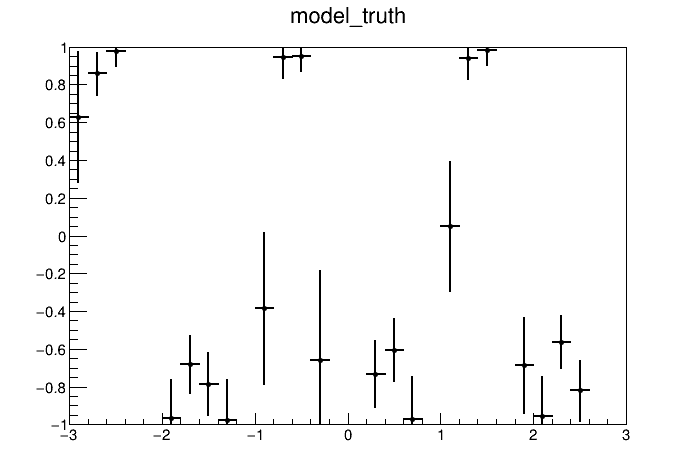

In [22]:
# You have to save the output histogram in a variable, else it will get deleted
databias = plotBias(real_test,data_test_bbb)

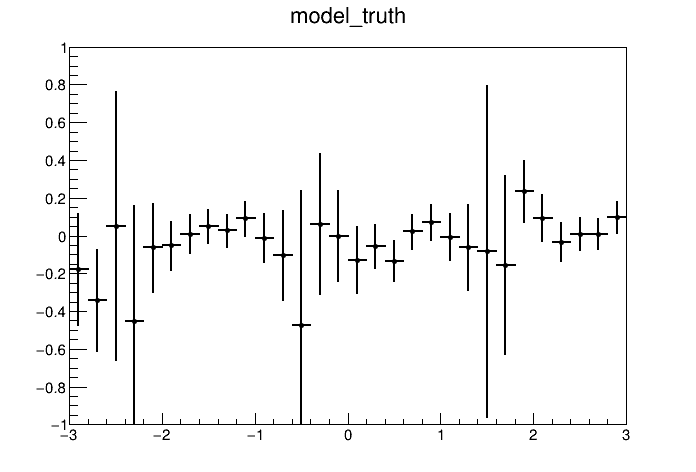

In [23]:
# You have to save the output histogram in a variable, else it will get deleted
modelbias = plotBias(model_truth,model_meas_test_bbb)

## Exercise 2: <div class="alert alert-block alert-info"> Plot the bias for your data and model when unfolded with bin-by-bin corrections to compare the following variations: 
 <div class="alert alert-block alert-info"> 
* Modify the detector effects to change the width of the smearing, the amount of bias offset or the efficiency function. Try switching off effects entirely. Under what conditions is the data relatively unbiased? 
* Try using different functional forms (sinusoidal, falling, peaking). Are some of these "safer" to unfold with the bin-by-bin corrections?

## Using RooUnfold

Now we move on to using the RooUnfold classes to do everything for us. The steps are pretty straightforward, and similar to what we just did. First, we generate the histograms for the true and measured values starting with the model function, but you can at any time switch to the "real" one for comparison. We will subsequently make use of the response we generated earlier.

In [25]:
print ("==================================== TEST =====================================")
# Create the truth and measured histograms
hTrue = ROOT.TH1D ("true", "Test Truth",    nbins,xmin,xmax)
hMeas = ROOT.TH1D ("meas", "Test Measured", nbins,xmin,xmax)
hTrue.Reset()
hMeas.Reset()

# Now fill them, using the model function
for i in range(10000):
    xtrue = freal.GetRandom()
    xreco = applyDetectorEffects(xtrue)
    hTrue.Fill(xtrue)
    if xreco!=None: hMeas.Fill(xreco)

==================================== TEST =====================================


Warning in <TROOT::Append>: Replacing existing TH1: true (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: meas (Potential memory leak).


Pick an unfolding method from the list of classes that we imported), provide the measured histogram to the unfolding class, then plot the true/measured/unfolded distributions. The 3rd argument supplied for the commented options specifies parameters for the regularisation procedure (see the RooUnfold documentation for the corresponding class).

Start by comparing the Bin-By-Bin and Matrix Inversion results to what we attempted above.

Try out the Bayes, SVD and IDS approaches, comparing the results you get for different values of this parameter.

Now fill the histograms with from `freal` rather than `fmodel`. Do any of the conclusions change?

==================================== UNFOLD ===================================
         Train    Train     Test     Test Unfolded  Error on     Diff     Pull
  Bin    Truth Measured    Truth    Input   Output Unfolding
    1     2326      411       22        2     11.3       8.0    -10.7     -1.3
    2      664     1270      142       20     10.5       2.3   -131.5    -56.3
    3       51      598      320      113      9.6       0.9   -310.4   -342.3
    4      720      151      522      231   1101.5      72.5    579.5      8.0
    5     2297      619      686      373   1384.1      71.7    698.1      9.7
    6     4352     1722      648      473   1195.4      55.0    547.4     10.0
    7     6108     2944      484      427    885.9      42.9    401.9      9.4
    8     6486     3858      363      333    559.8      30.7    196.8      6.4
    9     5889     4169      132      225    317.8      21.2    185.8      8.8
   10     4465     3614       26      100    123.5      12.4     97.5

input_line_209:7:55: warning: 'Hreco' is deprecated: #REASON [-Wdeprecated-declarations]
      new (ret) (TH1*) (((RooUnfoldT<TH1, TH2>*)obj)->Hreco());
                                                      ^
/home/prozorov/install/RooUnfold/src/RooUnfold.h:86:3: note: 'Hreco' has been explicitly marked deprecated here
  DEPRECATED("Hreco is considered ambigious and should no longer be used, please use Hunfold instead") virtual Hist* Hreco   () { return Hunfold(RooUnfolding::kErrors); }  
  ^
/home/prozorov/install/RooUnfold/src/RooUnfoldHelpers.h:14:30: note: expanded from macro 'DEPRECATED'
#define DEPRECATED(REASON) [[deprecated("#REASON")]]
                             ^
input_line_209:11:44: warning: 'Hreco' is deprecated: #REASON [-Wdeprecated-declarations]
      (void)(((RooUnfoldT<TH1, TH2>*)obj)->Hreco());
                                           ^
/home/prozorov/install/RooUnfold/src/RooUnfold.h:86:3: note: 'Hreco' has been explicitly marked deprecated here
  DEPRECATED("Hr

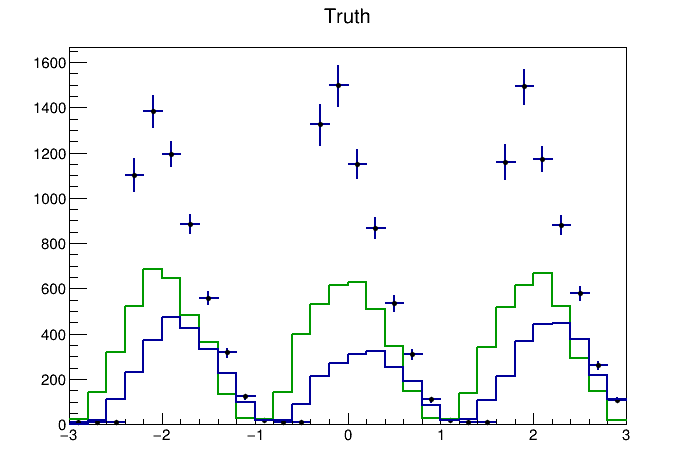

In [26]:
print("==================================== UNFOLD ===================================")
unfold = RooUnfoldBinByBin (response, hMeas)
# unfold = RooUnfoldInvert   (response, hMeas)
# unfold = RooUnfoldBayes    (response, hMeas, 4)
# unfold = RooUnfoldSvd     (response, hMeas, 20)     #  OR
# unfold = RooUnfoldIds     (response, hMeas, 3)    #  OR
hReco = unfold.Hreco().Clone("hReco_tmp") # clone this to avoid overwriting later
unfold.PrintTable (cout, hTrue)
hTrue.SetMarkerColor(ROOT.kGreen+2)
hTrue.SetLineColor(ROOT.kGreen+2)
hReco.Draw()
hTrue.Draw("SAME")
hMeas.Draw("SAME")

c.Draw()

After unfolding, we can gain useful information about the results in the form of the bin-to-bin covariance matrix. Let's plot this.

In [27]:
unfold.Ereco().Draw("colz")
c.Draw()

AttributeError: 'RooUnfoldBinByBinT<TH1,TH2>' object has no attribute 'Ereco'

In [28]:
unfold.ErecoV().Draw()
c.Draw()

AttributeError: 'RooUnfoldBinByBinT<TH1,TH2>' object has no attribute 'ErecoV'

## Exercise 3: <div class="alert alert-block alert-info"> Investigate the effects of regularisation </div>
<div class="alert alert-block alert-info">
* For the unfolding methods with regularisation, plot the unfolded distributions and their bias, for different values of the regularisation parameters (e.g. 1,2,4,5,10,20). How do these change as the amount of regularisation is increased? Besides the bias, do you see other trends in the results? 
* For different types of model functions, do you find that different unfolding methods behave differently?


## Effects of background

Above, we have assumed that we measure the signal on its own. But we inevitably have to deal with some level of background contamination, so let's insert a small background component (here we define it to be an exponential again), and see how this changes the unfolded results.

In [ ]:
print "==================================== TEST ====================================="
hMeas_bkg = ROOT.TH1D ("meas_bkg", "Test Measured w/ Bkg", nbins,xmin,xmax)
hBkg = ROOT.TH1D ("bkg", "Bkg distribution", nbins,xmin,xmax);

for i in xrange(10000):
    xtrue = freal.GetRandom()
    xreco = applyDetectorEffects(xtrue)
    if xreco!=None: hMeas_bkg.Fill(xreco);
# Add a background component
expbg = ROOT.TF1('expbg','exp(-(0.3*(x+{0})))'.format(xmin),xmin,xmax)
for i in xrange(2000):
    xbkg = expbg.GetRandom()
    hBkg.Fill(xbkg)
    hMeas_bkg.Fill(xbkg)

In [ ]:
print "==================================== UNFOLD ==================================="
unfold_bkg = RooUnfoldBayes   (response, hMeas_bkg, 4)    #  OR
# unfold_bkg = RooUnfoldSvd     (response, hMeas_bkg, 20)     #  OR
# unfold_bkg = RooUnfoldIds     (response, hMeas_bkg, 3)    #  OR
hReco_bkg = unfold_bkg.Hreco().Clone("hReco_bkg") # clone this to avoid overwriting later
unfold_bkg.PrintTable (cout, hTrue)
hTrue.SetLineColor(ROOT.kGreen+2)
#hTrue.GetYaxis().SetRangeUser(0,1.4*hTrue.GetMaximum())
hTrue.Draw()
hBkg.SetLineColor(ROOT.kRed)
hMeas_bkg.Draw("SAME")
hReco_bkg.Draw("SAME")
hBkg.Draw("SAME")

c.Draw()

## Dealing with background better

RooUnfold allows us to supply "fake" data, in other words a background model to be subtracted from the measured histogram before unfolding. So now, in the training step, we insert the background component and then let RooUnfold deal with it when unfolding.

In [ ]:
print "==================================== TRAIN ===================================="
response_w_fake = RooUnfoldResponse (nbins,xmin,xmax)

for i in xrange(100000):
    xtrue = freal.GetRandom()
    xreco = applyDetectorEffects(xtrue)
    if xreco!=None:
        response_w_fake.Fill (xreco, xtrue) # accepted event
    else:
        response_w_fake.Miss (xtrue);    # lost event
for i in xrange(20000):
    xbkg = expbg.GetRandom()
    response_w_fake.Fake(xbkg)

In [ ]:
print "==================================== UNFOLD ==================================="
unfold_bkgcorr = RooUnfoldBayes   (response_w_fake, hMeas_bkg, 4);    #  OR
# unfold_bkgcorr = RooUnfoldSvd     (response_w_fake, hMeas_bkg, 20);     #  OR
# unfold_bkgcorr = RooUnfoldIds     (response_w_fake, hMeas)bkg, 3);    #  OR
hReco_bkgcorr = unfold_bkgcorr.Hreco().Clone("hReco_bkgcorr") # clone this to avoid overwriting later
unfold_bkgcorr.PrintTable (cout, hTrue)
hTrue.SetLineColor(ROOT.kGreen+2)
hTrue.Draw()
hMeas_bkg.Draw("SAME")
hReco_bkgcorr.Draw("SAME")
hBkg.SetLineColor(ROOT.kRed)
hBkg.Draw("SAME")

c.Draw()

Comparing the results w/o background, and with background when we do/do not account for it, we hopefully see how important it is not to neglect our background estimates!

In [ ]:
hReco.SetMarkerColor(ROOT.kBlack)
hReco.SetLineColor(ROOT.kBlack)
hReco.Draw("pe")

hReco_bkg.SetMarkerColor(ROOT.kRed)
hReco_bkg.SetLineColor(ROOT.kRed)
hReco_bkg.SetLineWidth(2)
hReco_bkg.Draw("histSAME")

hReco_bkgcorr.SetMarkerColor(ROOT.kBlue)
hReco_bkgcorr.SetLineColor(ROOT.kBlue)
hReco_bkgcorr.Draw("histSAME")
c.Draw()

## Exercise 4: <div class="alert alert-block alert-info"> Incorrect background model</div>
 <div class="alert alert-block alert-info"> 
We have tested the effects of having background "on" or "off", but what if we merely have an imperfect background model? Try repeating the unfolding where you provide a "fake" component that is reasonably, but not perfectly accurate. What impact does this have on the bias and other measures of the unfolding quality? Does increasing the statistics for the training and/or test change this conclusion?